<h2><center><font color='blue'> Watershed Delineation

<h3><center><font color= 'teal'> Sushant Poudel

Workflow:
1. Extract the city of interest polygon vector file.
2. Merge multiple DEMs (USGS Earth Explorer)
3. Use the DEMs from step 2 and vector file from step 1 to find the lowest elevation within the city
limits.
4. Use a larger DEM to delineate a watershed (this is because the watershed boundary can be outside
the city limits). Plot the DEMs to find the upstream areas near the city to guide the size of the DEM
5. Delineate the watersheds using the Pysheds package (the illustration there is self-explanatory)
6. Polygonize and find the area of the corresponding watershed.

In [48]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
import geopandas as gpd
import matplotlib_map_utils as mu  # To draw north arrow
import rasterio
from rasterio.merge import merge
from rasterio.mask import mask
from matplotlib.colors import ListedColormap 
from rasterio.warp import transform_bounds, calculate_default_transform, reproject, Resampling
from pysheds.grid import Grid
from whitebox.whitebox_tools import WhiteboxTools
from shapely.geometry import Point, shape
import shapely.ops
from rasterio.features import shapes
from rasterio.enums import Resampling

In [49]:
path = "C:/Users/Sushant/OneDrive - Lamar University/1st semester/GIS/Project/Final Project/Waterhsed_Delineation"
os.chdir(path)

### List of BIL files

In [50]:
bilfiles = ['n29_w094_1arc_v2.bil','n29_w095_1arc_v2.bil','n30_w094_1arc_v2.bil','n30_w095_1arc_v2.bil']

### Open each file and add to a list of datasets

In [51]:
datasets = [rasterio.open(file) for file in bilfiles]

### Merge the datasets

In [52]:
mosaic, out_transform = merge(datasets)

### Get metadata from the first dataset to use for the output

In [53]:
out_meta = datasets[0].meta.copy()
out_meta.update({
    'driver': 'GTiff',
    'height': mosaic.shape[1],
    'width': mosaic.shape[2],
    'transform': out_transform
})

### Write the mosaic to a new file

In [54]:
with rasterio.open('mosaic_output.tif', 'w', **out_meta) as dest:
                   dest.write(mosaic)

### Close all the datasets

In [55]:
for dataset in datasets:
    dataset.close()#Import packages

### Open the raster file and print

In [56]:
raster_path = 'mosaic_output.tif' 
with rasterio.open(raster_path) as src:
    #Read the data
    data = src.read(1) 

    #Get the metadata
    metadata = src.profile
    print('Metadata:', metadata)

Metadata: {'driver': 'GTiff', 'dtype': 'int16', 'nodata': -32767.0, 'width': 7201, 'height': 7201, 'count': 1, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'), 'transform': Affine(0.000277777777777778, 0.0, -95.00013888888888,
       0.0, -0.000277777777777778, 31.000138888888888), 'blockxsize': 7201, 'blockysize': 1, 'tiled': False, 'interleave': 'band'}


### Plot the raster data

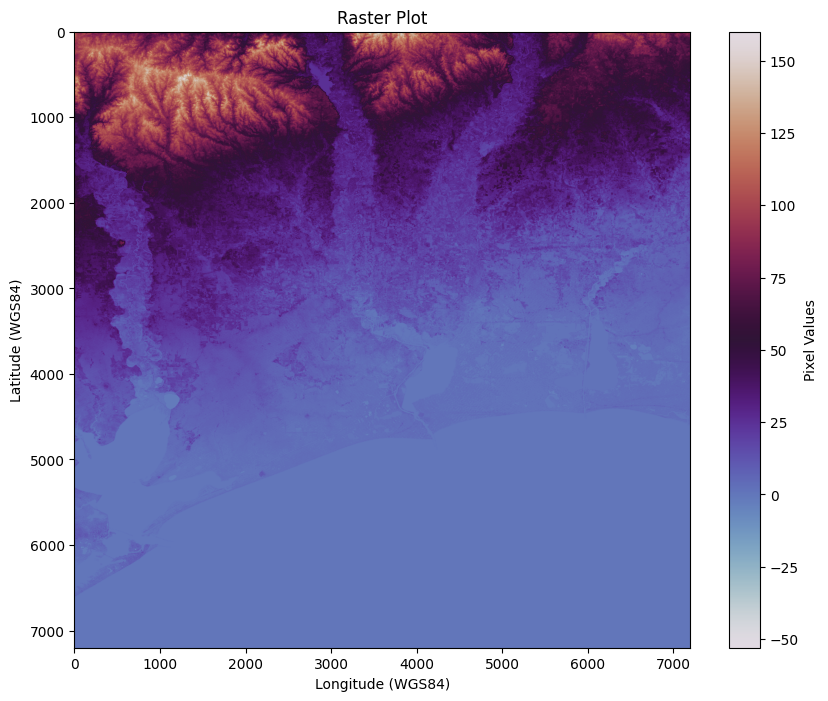

In [57]:
plt.figure(figsize=(10, 8))
plt.imshow(data, cmap = 'twilight') 
plt.colorbar(label = 'Pixel Values')
plt.xlabel('Longitude (WGS84)')
plt.ylabel('Latitude (WGS84)')
plt.title('Raster Plot')
plt.show()

C:\Users\Sushant\AppData\Local\ipykernel_24232\2338285380.py:9: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geo = gdf.geometry.unary_union


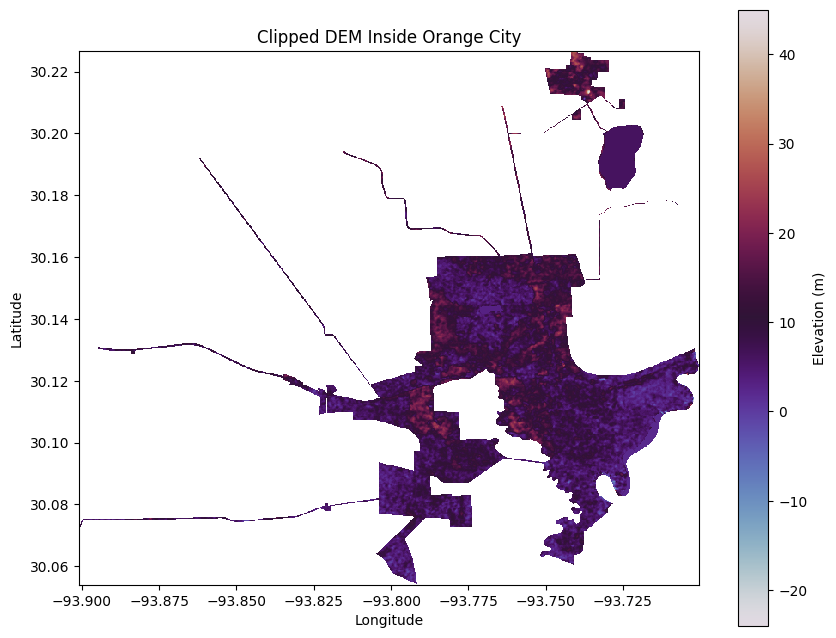

In [58]:
# Load the GeoDataFrame (city boundary from GeoPackage)
gpk_path = 'Orange_City_reprojected.gpkg' 
gdf = gpd.read_file(gpk_path)

# Load the DEM raster file
raster_path = 'mosaic_output.tif'  

with rasterio.open(raster_path) as src:
    geo = gdf.geometry.unary_union 
    out_image, out_transform = mask(src, [geo], crop=True, nodata=-9999)
    out_metadata = src.profile.copy()
    out_metadata.update({
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform,
        "nodata": -9999  
    })
    clipped_raster_path = "clipped_dem_inside_orange.tif"
    with rasterio.open(clipped_raster_path, 'w', **out_metadata) as dest:
        dest.write(out_image)

# Prepare the data for plotting
data = out_image[0] 
data_masked = np.where(data == -9999, np.nan, data) 
terrain_cmap = plt.cm.terrain(np.linspace(0, 1, 256))  
terrain_cmap[0, :] = [1, 1, 1, 1] 
custom_cmap = ListedColormap(terrain_cmap)
min_x, min_y = out_transform * (0, data.shape[0])  
max_x, max_y = out_transform * (data.shape[1], 0)  

# Plot with extent for geospatial axes
plt.figure(figsize=(10, 8))
plt.imshow(data_masked, cmap='twilight', extent=(min_x, max_x, min_y, max_y), interpolation="none")
plt.colorbar(label='Elevation (m)')
plt.title('Clipped DEM Inside Orange City')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [59]:
# Mask the nodata values
masked_data = np.ma.masked_equal(data, -9999)  
row, col = np.unravel_index(np.argmin(masked_data), data.shape)
lowest_point_coords = rasterio.transform.xy(out_transform, row, col, offset='center')
masked_data_above_zero = np.ma.masked_less_equal(data, 0)
row_above_zero, col_above_zero = np.unravel_index(np.argmin(masked_data_above_zero), data.shape)
lowest_point_coords_above_zero = rasterio.transform.xy(out_transform, row_above_zero, col_above_zero, offset='center')
lowest_point = data[row, col]
lowest_point_above_zero = data[row_above_zero, col_above_zero]

# Print results
print(f"The lowest elevation point inside Orange City is at {lowest_point_coords} with elevation {lowest_point:.2f} meters.")
print(f"The lowest elevation point above 0 inside Orange City is at {lowest_point_coords_above_zero} with elevation {lowest_point_above_zero:.2f} meters.")

The lowest elevation point inside Orange City is at (-93.70222222222222, 30.11361111111111) with elevation -24.00 meters.
The lowest elevation point above 0 inside Orange City is at (-93.7375, 30.210833333333333) with elevation 1.00 meters.


<H1>Read DEM data</H1>


In [13]:
grid = Grid.from_raster('clipped_dem_inside_orange.tif')
dem = grid.read_raster('clipped_dem_inside_orange.tif')

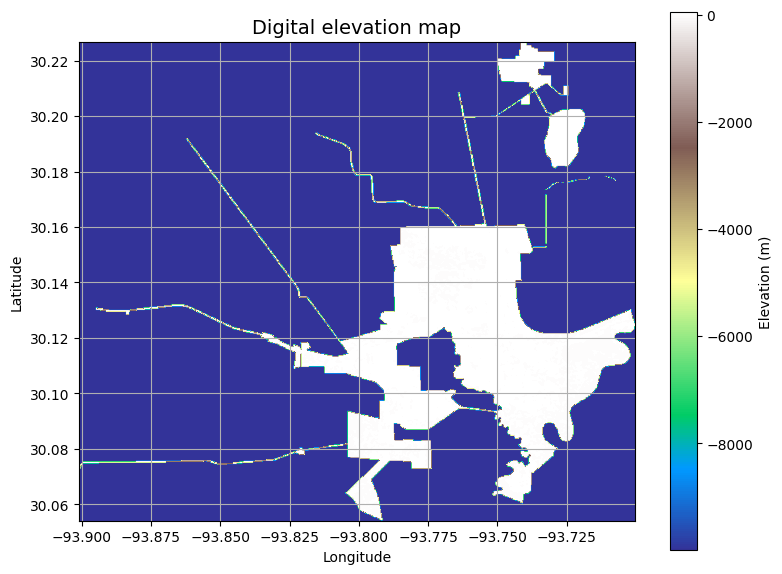

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(dem, extent=grid.extent, cmap='terrain', zorder=1)
plt.colorbar(label='Elevation (m)')
plt.grid(zorder=0)
plt.title('Digital elevation map', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

<H2>Condition the elevation data</H2>


In [15]:
# Condition DEM
# ----------------------
# Fill pits in DEM
pit_filled_dem = grid.fill_pits(dem)

# Fill depressions in DEM
flooded_dem = grid.fill_depressions(pit_filled_dem)
    
# Resolve flats in DEM
inflated_dem = grid.resolve_flats(flooded_dem)

<H2>Elevation to flow direction

</H2>

In [16]:
# Determine D8 flow directions from DEM
# ----------------------
# Specify directional mapping
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)
    
# Compute flow directions
# -------------------------------------
fdir = grid.flowdir(inflated_dem, dirmap=dirmap)

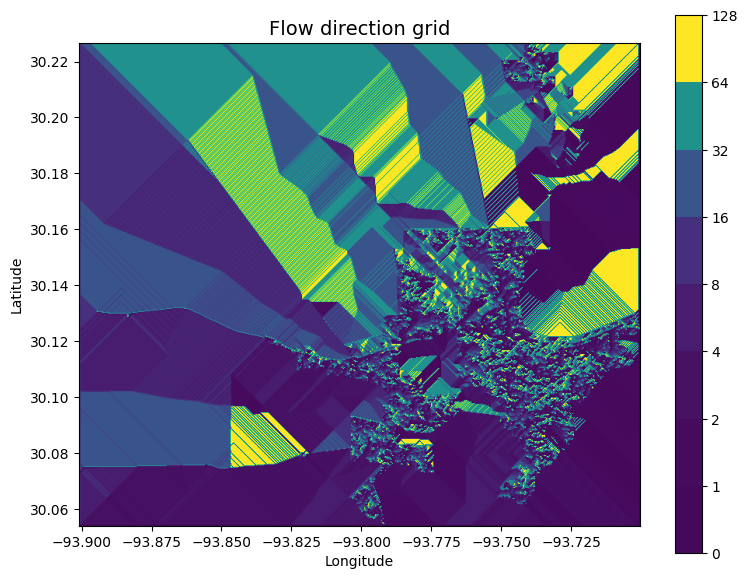

In [17]:
fig = plt.figure(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(fdir, extent=grid.extent, cmap='viridis', zorder=2)
boundaries = ([0] + sorted(list(dirmap)))
plt.colorbar(boundaries= boundaries,
             values=sorted(dirmap))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Flow direction grid', size=14)
plt.grid(zorder=-1)
plt.tight_layout()

<H2>Compute accumulation from flow direction</H2>

In [43]:
# Calculate flow accumulation
# --------------------------
acc = grid.accumulation(fdir, dirmap=dirmap)

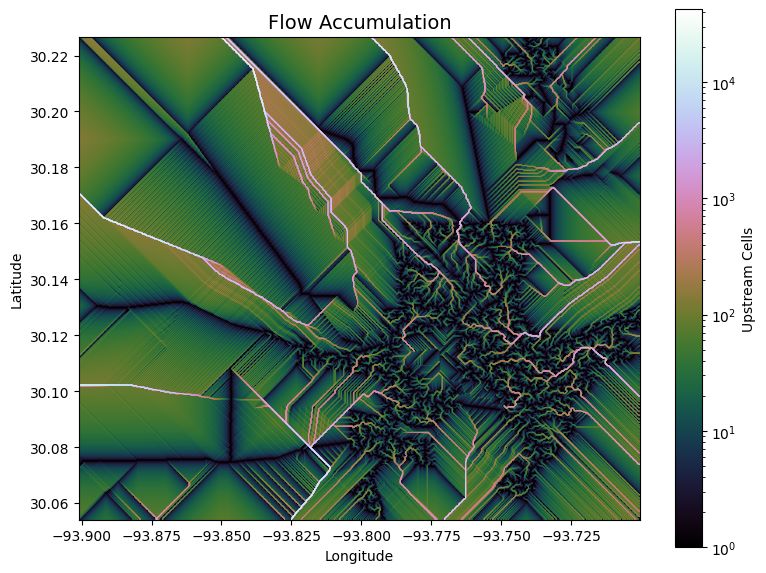

In [19]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
im = ax.imshow(acc, extent=grid.extent, zorder=2,
               cmap='cubehelix',
               norm=colors.LogNorm(1, acc.max()),
               interpolation='bilinear')
plt.colorbar(im, ax=ax, label='Upstream Cells')
plt.title('Flow Accumulation', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

<H2>Delineate catchment from flow direction
</H2>

In [20]:
# Delineate a catchment
# ---------------------
# Specify pour point
x, y = -93.70222222222222, 30.11361111111111

# Snap pour point to high accumulation cell
x_snap, y_snap = grid.snap_to_mask(acc > 1000, (x, y))

# Delineate the catchment
catch = grid.catchment(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap, 
                       xytype='coordinate')

# Crop and plot the catchment
# ---------------------------
# Clip the bounding box to the catchment
grid.clip_to(catch)
clipped_catch = grid.view(catch)

Text(0.5, 1.0, 'Delineated Catchment')

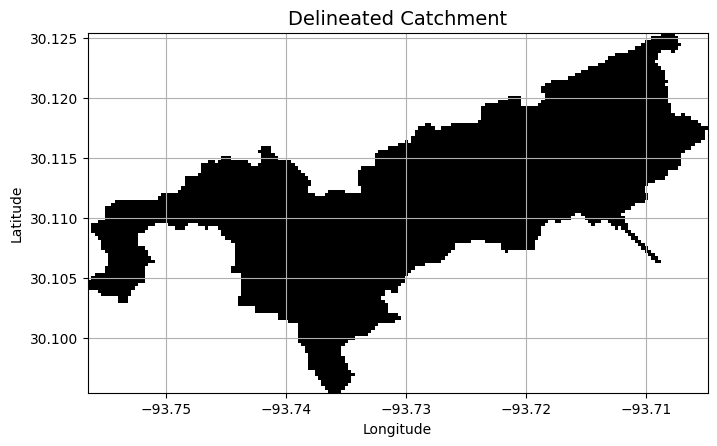

In [21]:
# Plot the catchment
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.grid('on', zorder=1)
im = ax.imshow(np.where(clipped_catch, clipped_catch, np.nan), extent=grid.extent,
               zorder=1, cmap='Greys_r')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Delineated Catchment', size=14)

<H1>Caculation of the area</H1>

In [37]:
aea_epsg = 5070
with rasterio.open('clipped_dem_inside_orange.tif') as src:
    src_crs = src.crs
    transform, width, height = rasterio.warp.calculate_default_transform(
        src.crs, aea_epsg, src.width, src.height, *src.bounds)
    reprojected_raster = 'reprojected_clipped_dem.tif'
    with rasterio.open(reprojected_raster, 'w', driver='GTiff', 
                       height=height, width=width, 
                       count=1, dtype='float32',
                       crs=aea_epsg, transform=transform) as dst:
        reproject(
            source=rasterio.band(src, 1), 
            destination=rasterio.band(dst, 1),
            src_transform=src.transform, 
            src_crs=src_crs, 
            dst_transform=transform, 
            dst_crs=aea_epsg, 
            resampling=Resampling.nearest)
        
    with rasterio.open(reprojected_raster) as reprojected_src:
        catchment_data = reprojected_src.read(1)
        
        mask = catchment_data > 0  
        results = features.shapes(catchment_data, mask=mask, transform=reprojected_src.transform)
        polygons = []
        for geom, value in results:
            if value > 0:  
                geom = shape(geom)  
                polygons.append(geom)
        
        catchment_polygon = polygons[0] if len(polygons) == 1 else unary_union(polygons)
        area_sq_meters = catchment_polygon.area
        area_sq_km = area_sq_meters / 1_000_000  
        print(f"Area of the delineated catchment: {area_sq_km:.6f} square kilometers ({area_sq_meters:.2f} square meters).")
        gdf = gpd.GeoDataFrame(geometry=[catchment_polygon])
        gdf.set_crs(aea_epsg, inplace=True) 
        gdf.to_file('delineated_catchment_aea.shp')  

Area of the delineated catchment: 61.951081 square kilometers (61951080.86 square meters).


<H2>Extract the river network

</H2>

In [35]:
# Extract river network
# ---------------------
branches = grid.extract_river_network(fdir, acc > 100, dirmap=dirmap)

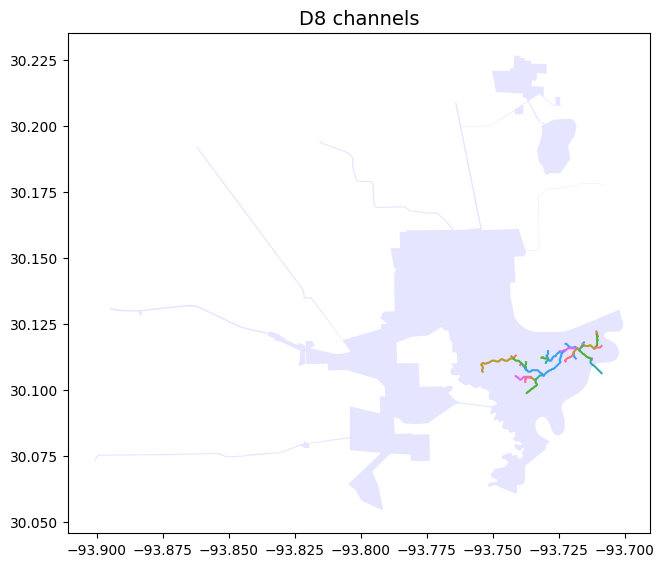

In [23]:
sns.set_palette('husl')
fig, ax = plt.subplots(figsize=(8.5,6.5))
gdf.plot(ax=ax, color='blue', alpha=0.1, label='Orange City')

ax.set_aspect('equal')

for branch in branches['features']:
    line = np.asarray(branch['geometry']['coordinates'])
    plt.plot(line[:, 0], line[:, 1])
    
_ = plt.title('D8 channels', size=14)

<H2>Compute flow distance from flow direction


</H2>

In [24]:
# Calculate distance to outlet from each cell
# -------------------------------------------
dist = grid.distance_to_outlet(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap,
                               xytype='coordinate')

Text(0.5, 1.0, 'Flow Distance')

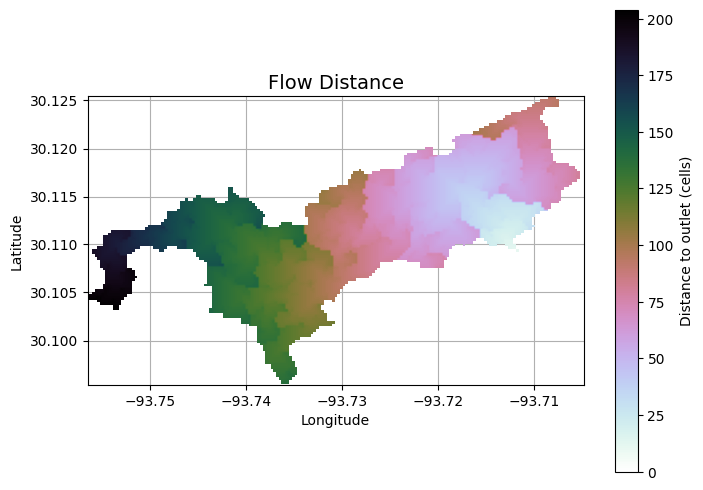

In [25]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
im = ax.imshow(dist, extent=grid.extent, zorder=2,
               cmap='cubehelix_r')
plt.colorbar(im, ax=ax, label='Distance to outlet (cells)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Flow Distance', size=14)